# texture-diffusion
using my local huggingface env

https://huggingface.co/dream-textures/texture-diffusion

In [30]:
from diffusers import StableDiffusionPipeline
from matplotlib import pyplot as plt
import torch
from IPython.display import Image

model_id = "dream-textures/texture-diffusion"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "pbr brick wall"
image = pipe(prompt).images[0]  
    
image.save("bricks.png")


vae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\willi\.cache\huggingface\hub\models--dream-textures--texture-diffusion\snapshots\981e240aab8807bbf8b04afdb7f5c3f893c22e43\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\willi\.cache\huggingface\hub\models--dream-textures--texture-diffusion\snapshots\981e240aab8807bbf8b04afdb7f5c3f893c22e43\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\willi\.cache\huggingface\hub\models--dream-textures--texture-diffusion\snapshots\981e240aab8807bbf8b04afdb7f5c3f893c22e43\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\willi\.cache\huggingface\hub\models--dream-textures--texture-diffusion\snapshots\981e240aab8807bbf8b04afdb7f5c3f893c22e43\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

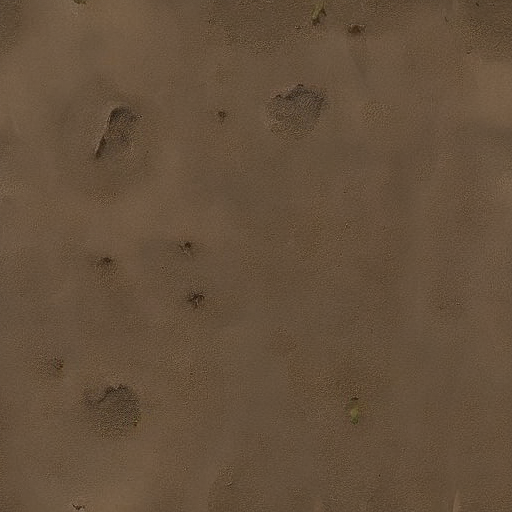

In [31]:
def make_image(prompt,path="default.png"):
    image = pipe(prompt).images[0] 
    image.save(path)
    return image

prompt = "pbr lifeless planet surface.  game texture surface"
image = make_image(prompt)
Image(filename="default.png")



Loop through a range of textures 

In [32]:

prompt = "pbr A habitable planet.With blue oceans and green continents. Mountains, rivers, lakes, big blue oceans. game texture surface"
for i in range(5):
    image = make_image(prompt,f"planet_{i}.png")
    

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

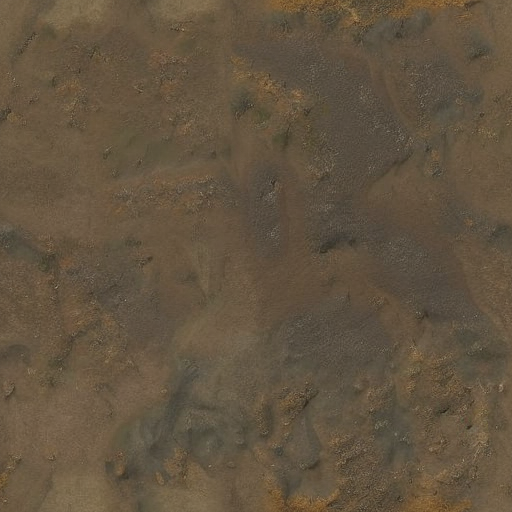

In [33]:
Image(filename=f"planet_{3}.png")

# Using data from the game to make the textures

In [13]:
import sys, os
sys.path.append('../..')
import pandas as pd
import yaml 

import  ssl, asyncio
ssl._create_default_https_context = ssl._create_unverified_context
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
import nest_asyncio
nest_asyncio.apply()
# this is required for running in a Jupyter Notebook. 


from app.connectors.cmdb_graph import CosmosdbClient
c = CosmosdbClient()

executing local windows deployment
something wrong with your query: <class 'Exception'>


In [14]:
query = """
    g.V().hasLabel('planet').has('atmosphere').valueMap()
"""

c.run_query(query)

In [15]:
data = c.clean_nodes(c.res)

In [16]:
def get_top_two_atmo(planet):
    atmo = yaml.safe_load(planet['atmosphere'])
    atmo_names = (pd.DataFrame(
        {k: v for d in atmo for k, v in d.items()}
        ,index=['value'])
            .T
            .sort_values(by='value',ascending=False)[:2]).index

    return ' and '.join(atmo_names)


get_top_two_atmo(data[0])

'Hydrogen and Argon'

In [17]:
pd.DataFrame(data)

,atmosphere,name,class,objid,pop_cap,radius,mass,orbitsDistance,orbitsId,orbitsName,isSupportsLife,isPopulated,isHomeworld,userguid,objtype,id
0,"[{Argon: np.float64(0.198)}, {Carbon Dioxide: ...",Dessevertor,terrestrial,6900299438808,100,0.662,1.489,0.639,3904198844110,Fran,true,true,true,ac5b8081-7ef9-4bce-baac-6d0ea7e1782c,planet,6900299438808
1,"[{Argon: 0.23}, {Carbon Dioxide: 0.123}, {Heli...",Velgua,terrestrial,8227114694613,100,0.722,0.852,0.905,8727610707382,Fiporgi,true,true,true,9555d9ba-4564-43a7-ad7f-f06d3174cd24,planet,8227114694613
2,"[{Argon: np.float64(0.264)}, {Carbon Dioxide: ...",Rezdibarve,terrestrial,5941709224109,100,1.038,0.956,1.035,6629152792628,Sno,true,true,true,6e9492d5-44af-4a8e-90ac-1237e87688d6,planet,5941709224109
3,"[{Argon: np.float64(0.232)}, {Carbon Dioxide: ...",Stacas,terrestrial,4099727308523,100,0.575,0.695,1.437,5194242631161,Kesgo,true,true,true,e6606730-e180-48b6-8697-c7dd570a847e,planet,4099727308523
4,"[{Argon: np.float64(0.131)}, {Carbon Dioxide: ...",South,terrestrial,9610352969531,100,0.725,1.14,1.425,0991160450148,Ty,true,true,true,8d5b667f-b225-4641-b499-73b77558ff86,planet,9610352969531


In [18]:
for planet in data:
    print(planet['name'])

Dessevertor
Velgua
Rezdibarve
Stacas
South


In [57]:
def get_most_common_eliments(atmosphere):
    elements = atmosphere.split(",")
    elements = [element.strip() for element in elements]
    elements = [element for element in elements if element != ""]
    return elements


def planet_prompt(planet):
    prompt = f"A habitable planet. With {get_top_two_atmo(planet)}. "
    if planet['isPopulated'] == 'true':
        prompt += "Populated with intelligent life. "
    if planet['isSupportsLife'] == 'true':
        prompt += "the planet supports life. "
    prompt += "game texture surface. should look like a top-down picture of map, stretched out from a sphere to a square. There should be oceans and long windy continents. Should not contain a planet as it is a picture of a planet. No blotches or spheres in the texture"
    return prompt


prompts = []
for planet in data:
    pprompt = planet_prompt(planet)
    print(planet['name'],": ", pprompt)
    prompts.append(pprompt)
    


Dessevertor :  A habitable planet. With Hydrogen and Argon. Populated with intelligent life. the planet supports life. game texture surface. should look like a top-down picture of map, stretched out from a sphere to a square. There should be oceans and long windy continents. Should not contain a planet as it is a picture of a planet. No blotches or spheres in the texture
Velgua :  A habitable planet. With Nitrogen and Argon. Populated with intelligent life. the planet supports life. game texture surface. should look like a top-down picture of map, stretched out from a sphere to a square. There should be oceans and long windy continents. Should not contain a planet as it is a picture of a planet. No blotches or spheres in the texture
Rezdibarve :  A habitable planet. With Carbon Dioxide and Argon. Populated with intelligent life. the planet supports life. game texture surface. should look like a top-down picture of map, stretched out from a sphere to a square. There should be oceans and

In [58]:
imgs = []
for planet in data:
    pprompt = planet_prompt(planet)
    image = make_image(pprompt,path=f"planet_{planet['objid']}.png")
    imgs.append(image)

Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['texture']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['texture']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the texture']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['texture']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['texture']


  0%|          | 0/50 [00:00<?, ?it/s]

Dessevertor :  A habitable planet. With Hydrogen and Argon. Populated with intelligent life. the planet supports life. game texture surface. should look like a top-down picture of map, stretched out from a sphere to a square. There should be oceans and long windy continents. Should not contain a planet as it is a picture of a planet. No blotches or spheres in the texture
Velgua :  A habitable planet. With Nitrogen and Argon. Populated with intelligent life. the planet supports life. game texture surface. should look like a top-down picture of map, stretched out from a sphere to a square. There should be oceans and long windy continents. Should not contain a planet as it is a picture of a planet. No blotches or spheres in the texture
Rezdibarve :  A habitable planet. With Carbon Dioxide and Argon. Populated with intelligent life. the planet supports life. game texture surface. should look like a top-down picture of map, stretched out from a sphere to a square. There should be oceans and

<Figure size 1500x1500 with 0 Axes>

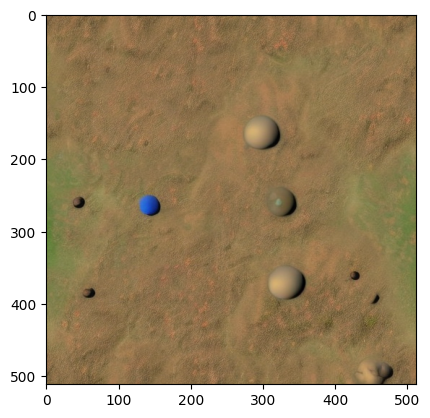

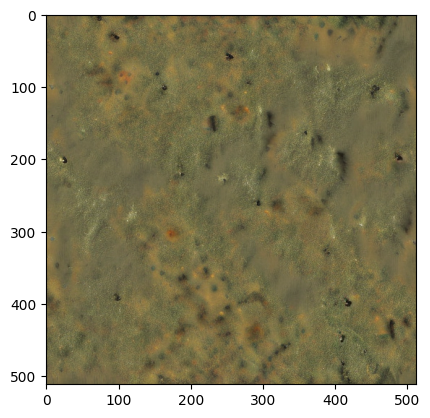

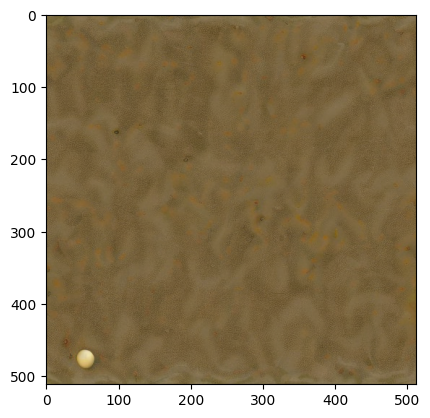

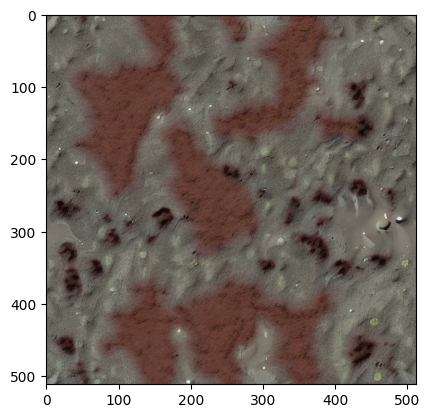

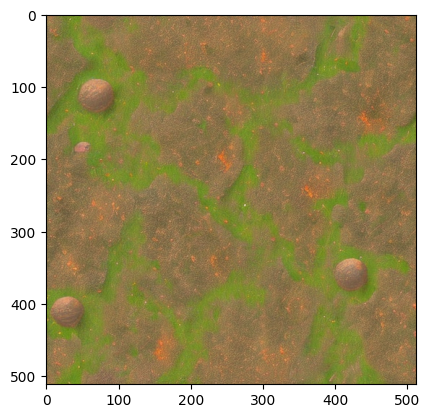

In [59]:
plt.gcf().set_size_inches(15, 15)

for i, ima in enumerate(imgs):
    plt.figure()
    print(data[i]['name'],": ", prompts[i])
    plt.imshow(ima)

    